In [2]:
import time, os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Data load

In [3]:
actions = ['palm', 'quiet', 'grab', 'pinch']

datas = np.load('dataset/raw_data.npy')

x_data = datas[:, :-1]
labels = datas[:, -1]

y_data = to_categorical(labels, num_classes=len(actions))
print(y_data.shape)

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)



(226280, 4)
(181024, 99) (181024, 4)
(45256, 99) (45256, 4)


## model 생성

In [3]:
model = Sequential([
    InputLayer(input_shape=x_train.shape[1]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 68,964
Trainable params: 68,964
Non-trainable params: 0
_________________________________________________________________


## train

In [8]:
filepath = 'models/raw_data_loss2.h5'

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    ]
)


Epoch 1/100
5610/5657 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9995    

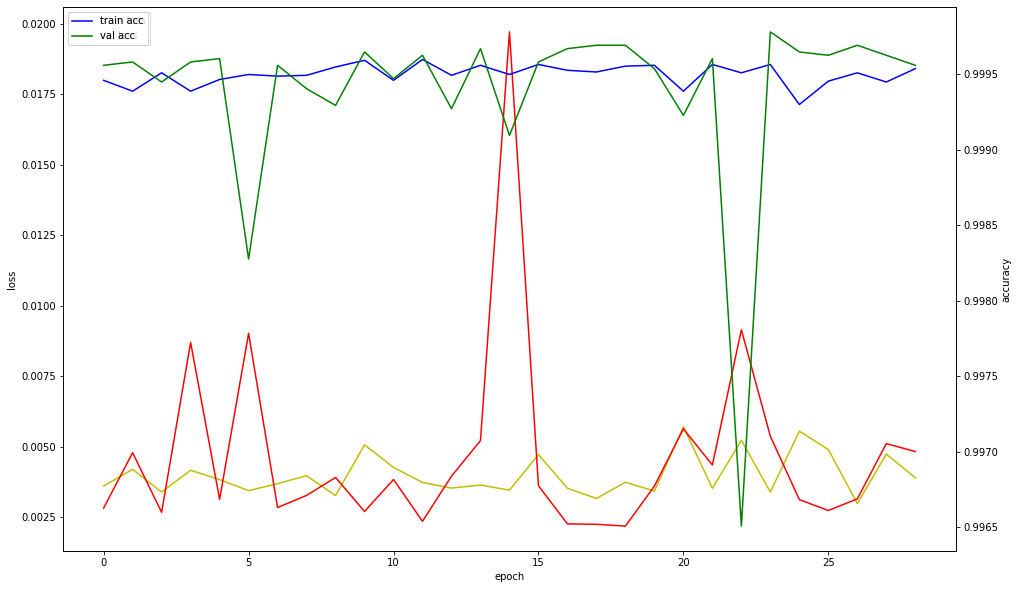

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()


In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/raw_data_loss.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))


array([[[34665,     1],
        [    0, 10590]],

       [[36069,     3],
        [    3,  9181]],

       [[33709,    10],
        [    3, 11534]],

       [[31311,     0],
        [    8, 13937]]], dtype=int64)

## model evaluation

In [11]:
val_loss, val_acc = model.evaluate(x_val, y_val, batch_size=128)


354/354 [==============================] - 0s 969us/step - loss: 0.0025 - acc: 0.9997
